# Read in the data

In [30]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
surv_corr = combined.corr()
surv_corr = surv_corr["sat_score"]
surv_corr = surv_corr[survey_fields]
print(surv_corr)

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


([<matplotlib.axis.XTick at 0x7f7da5bd8a90>,
 <a list of 22 Text xticklabel objects>)

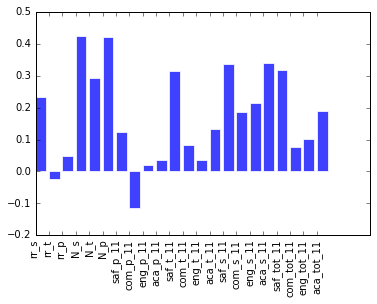

In [12]:
plt.bar(range(0,22), height=surv_corr, alpha=0.75, edgecolor="w")
plt.xticks(range(0,22), surv_corr.keys(), rotation=90)

Seeing the correlation of the survey fields, there's an apparent direct correlation between the number of survey respondents (be it student, parent or teacher) and the SAT score. Similar results can be seen on the safety and communication fields. Since those fields are related to involvement, it's likely that more involved actors produce better SAT results.

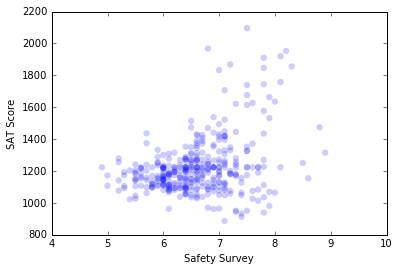

In [28]:
plt.scatter(x=combined["saf_s_11"], y=combined["sat_score"], s=40, alpha=0.2, edgecolor="None")
plt.xlabel("Safety Survey")
plt.ylabel("SAT Score")
plt.show()

There's a noticeable correlation between the perceived safety of the school and the overall SAT Scores. Most schools fall in the 5-7 range for safety and in the 1000-1400 score for the SAT. Then we have a block of schools that go above 7 in security and whose SAT score blows up above 1600 and even reaching 2000. On the other hand, the four schools with the highest safety rating fall well within the SAT average range. So security is not the only factor, and probably not the main one.

In [36]:
dist_safety = combined.groupby("school_dist").agg(np.mean)
dist_safety.reset_index(inplace=True)
dist_safety

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
5,06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
7,08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
8,09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,10.0,...,12.0,12.0,10463.181818,757.863636,1.500000,0.0,0.0,0.0,40.870345,-73.898360


In [41]:
dist_lon = dist_safety["lon"].tolist()
dist_lat = dist_safety["lat"].tolist()

In [47]:
from mpl_toolkits.basemap import Basemap as bsm

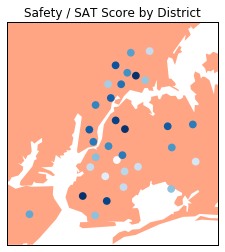

In [86]:
m = bsm(projection="merc", llcrnrlat=min(dist_lat)-0.05, urcrnrlat=max(dist_lat)+0.05,
       llcrnrlon=min(dist_lon)-0.05, urcrnrlon=max(dist_lon)+0.05, lat_ts=10, resolution="h")
m.drawrivers()
m.fillcontinents(color="coral", lake_color="aqua", alpha=0.7)
m.scatter(x=dist_lon, y=dist_lat, c=dist_safety["saf_s_11"], cmap="Blues", zorder=2, s=60, edgecolor="None", latlon=True)
plt.title("Safety / SAT Score by District")
plt.show()

    

From the geographical observation, Manhattan seems to be the borough with the highest amount of safe districts.

In [89]:
racial_score = combined[["white_per", "asian_per", "black_per", "hispanic_per", "sat_score"]].corr()
racial_score = racial_score["sat_score"]
racial_score

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
sat_score       1.000000
Name: sat_score, dtype: float64

White and Asian performance has a high direct correlaton with the SAT, while Hispanic and Black has mild inverse correlation. Seems that if you're White, you do the best and if you're Hispanic, you do the worst. 

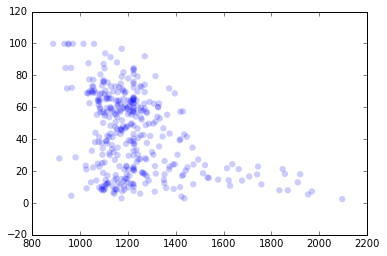

In [94]:
plt.scatter(x=combined["sat_score"], y=combined["hispanic_per"], c="blue", alpha= 0.2, s=40, edgecolor="None")
plt.show()

By and large, schools with a higher Hispanic performance tend to have the worst SAT scores, while the lowest the Hispanic performance, the highest the overall SAT score.

In [124]:
combined[combined["SCHOOL NAME"].str.contains("Journ")]["SCHOOL NAME"]

Series([], Name: SCHOOL NAME, dtype: object)

In [104]:
combined[combined["hispanic_per"] > 95]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


The Hispanic majority schools with the worst performance are mostly Dominican / Puerto Rican, the students tend to come from very poor backgrounds, which hampers their opportunities.

In [105]:
gender_score = combined[["male_per", "female_per", "sat_score"]].corr()
gender_score = gender_score["sat_score"]
gender_score

male_per     -0.112062
female_per    0.112108
sat_score     1.000000
Name: sat_score, dtype: float64

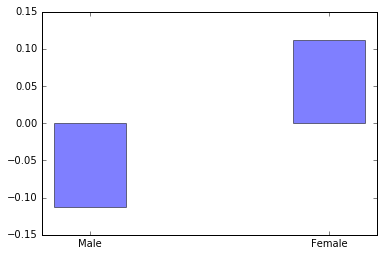

In [156]:
plt.bar(range(0,2), gender_score[:2], width=0.3, align="center", alpha=0.5)
plt.xticks(range(0,2), ["Male", "Female"])
plt.show()

Performance between male-majority and female-majority schools is total opposite.

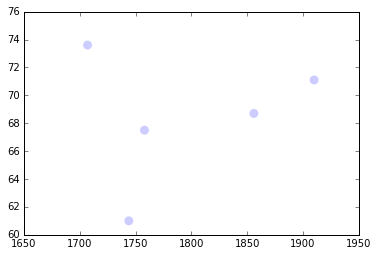

In [174]:
high_femsat = combined[combined["female_per"] > 60][["sat_score","female_per", "SCHOOL NAME"]]
high_femsat = high_femsat[high_femsat["sat_score"] > 1700]
plt.scatter(x=high_femsat["sat_score"], y=high_femsat["female_per"], c="blue", alpha= 0.2, s=80, edgecolor="None")
plt.show()

If we look at schools with female majority and SAT higher than 1400, we'll see a clear correlation between them.

In [175]:
high_femsat

,sat_score,female_per,SCHOOL NAME
5,1856.0,68.7,BARD HIGH SCHOOL EARLY COLLEGE
26,1758.0,67.5,ELEANOR ROOSEVELT HIGH SCHOOL
60,1744.0,61.0,BEACON HIGH SCHOOL
61,1707.0,73.6,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302,1910.0,71.1,TOWNSEND HARRIS HIGH SCHOOL


These are the highest ranked schools with a majority-female student body. Interestingly, all of them are public, which counters the perception that private schools are better. Another interesting fact is that four of them offer highly-advanced classes, although that might be a consequence of an excellent student body rather than being the cause itself. But it's undeniable that regardless of which causes what, the feedback loop between great students and stimulating classes produces amazing results.

In [176]:
combined["ap_per"] = round(combined["AP Test Takers "] / combined["total_enrollment"] * 100, 2)

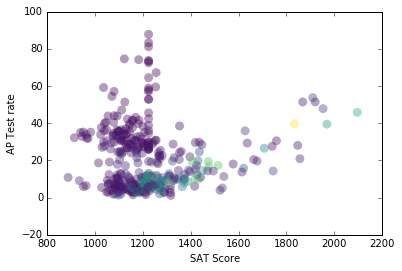

In [186]:
plt.scatter(x=combined["sat_score"], y=combined["ap_per"], c=combined["total_enrollment"], cmap="viridis", alpha= 0.4, s=80, edgecolor="None")
plt.xlabel("SAT Score")
plt.ylabel("AP Test rate")
plt.show()

The results for this plot are a bit confusing. We used *total_enrollment* as an argument for color, and used it *viridis* to map it. We see a curve that both low and high SAT score correlates with moderate amount of AP testers. Scores around the 1300-14000 range present the lowest level of AP takers. There's a strange phenomenon on the 1200 point where schools go on a straight vertical line of AP takers.

Interestingly, the schools with a high enrollment have a higher correlation between SAT scores and AP test rate, with the highest enrollment school being among the best rated.

In [229]:
class_size = combined[["AVERAGE CLASS SIZE", "sat_score", "SCHOOL NAME", "female_per"]]
class_size = class_size.groupby("SCHOOL NAME").agg(np.mean)
class_size.reset_index(inplace=True)
class_size

,SCHOOL NAME,AVERAGE CLASS SIZE,sat_score,female_per
0,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16.072727,1182.000000,57.5
1,A. PHILIP RANDOLPH CAMPUS HIGH SCHOOL,30.042105,1309.000000,50.1
2,ABRAHAM LINCOLN HIGH SCHOOL,27.668421,1226.000000,43.6
3,ACADEMY FOR CAREERS IN TELEVISION AND FILM,22.363636,1255.000000,46.8
4,ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...,24.813333,1139.000000,46.2
5,ACADEMY FOR CONSERVATION AND THE ENVIRONMENT,19.600000,1111.000000,45.3
6,ACADEMY FOR ENVIRONMENTAL LEADERSHIP,22.406250,1098.000000,50.0
7,ACADEMY FOR LANGUAGE AND TECHNOLOGY,23.714286,951.000000,51.2
8,ACADEMY FOR SCHOLARSHIP AND ENTREPRENEURSHIP: ...,28.157143,1141.000000,48.0
9,ACADEMY FOR SOCIAL ACTION: A COLLEGE BOARD SCHOOL,23.430769,1062.000000,51.3


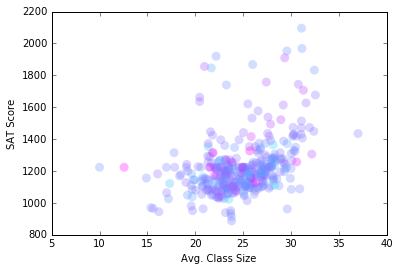

In [231]:
plt.scatter(x=class_size["AVERAGE CLASS SIZE"], y=class_size["sat_score"], c=class_size["female_per"], cmap="cool", alpha= 0.3, s=80, edgecolor="None")
plt.xlabel("Avg. Class Size")
plt.ylabel("SAT Score")
plt.show()

Seems there's a parabolic curve in the correlation between class size and SAT score, and yes, schools with higher avg class size will perform better.

In [239]:
borough = []
for a in range(len(combined["DBN"])):
    temp = combined["DBN"][a][2]
    borough.append(temp)
combined["borough"] = borough

In [240]:
boro = combined[["borough", "sat_score"]]
boro = boro.groupby("borough").agg(np.mean)
boro.reset_index(inplace=True)
boro

,borough,sat_score
0,K,1181.364461
1,M,1278.331410
2,Q,1286.753032
3,R,1382.500000
4,X,1157.598203


After tallying the average SAT score per borough